# Allocate Benchmarks

In [1]:
# select measurement file
file_name = "../output/2024-08-28 09-53-03 full.json"

# select style options
grey_fill_between = False

enable_storage_reference = False

if grey_fill_between:
    fill_between_args = {"color": "grey"}
else:
    fill_between_args = {}


In [2]:
# parse data
import json

with open(file_name) as file:
    raw_data = json.load(file)

In [3]:
from util.convert import convert_data
from IPython.core.display import HTML

# filter and convert data
allocate_min = convert_data(raw_data, "allocate_min", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])
allocate_max = convert_data(raw_data, "allocate_max", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])
allocate_case1 = convert_data(raw_data, "allocate_case_1", ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"])

display(HTML("<b>MIN Data:</b>"))
display(allocate_min.head())
display(HTML("<b>MAX Data:</b>"))
display(allocate_max.head())
display(HTML("<b>Case 1 Data:</b>"))
display(allocate_case1.head())

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,849.000,849,849,0,esp32c3,100,1000,16000
1,889.000,889,889,32,esp32c3,100,1000,16000
2,915.000,915,915,64,esp32c3,100,1000,16000
3,942.000,942,942,96,esp32c3,100,1000,16000
4,969.125,969,1094,128,esp32c3,100,1000,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,67685.0,67685,67685,0,esp32c3,100,1000,16000
1,50546.0,50546,50546,32,esp32c3,100,1000,16000
2,40114.0,40114,40114,64,esp32c3,100,1000,16000
3,47958.0,47958,47958,96,esp32c3,100,1000,16000
4,48178.0,48178,48178,128,esp32c3,100,1000,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,64220.0,64220,64220,0,esp32c3,100,1000,16000
1,39319.0,39319,39319,32,esp32c3,100,1000,16000
2,35973.0,35973,35973,64,esp32c3,100,1000,16000
3,32628.0,32628,32628,96,esp32c3,100,1000,16000
4,32654.0,32654,32654,128,esp32c3,100,1000,16000


In [4]:
from util.convert import scale_data

for (dataset, name) in [(allocate_min, "MIN"), (allocate_max, "MAX"), (allocate_case1, "CASE 1")]:
    scaled_data = scale_data(dataset, "us")
    display(HTML(f"<b>{name}:</b>"))
    display(scaled_data["mean"].agg(["min", "max"]))

min     53.0625
max    102.4375
Name: mean, dtype: float64

min    2117.3125
max    4230.3125
Name: mean, dtype: float64

min     503.6875
max    4013.7500
Name: mean, dtype: float64

In [5]:
from util.convert import get_storage_measurement
from IPython.core.display import HTML

(storage_read, storage_write) = get_storage_measurement(raw_data, allocate_max["options.object_size"].max())

display(HTML("<b>READ Data:</b>"))
display(storage_read.head())
display(HTML("<b>WRITE Data:</b>"))
display(storage_write.head())

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,616.0,616,616,0,esp32c3,100,1000,16000
1,1095.0,1095,1095,32,esp32c3,100,1000,16000
2,1433.0,1433,1433,64,esp32c3,100,1000,16000
3,1910.0,1910,1910,96,esp32c3,100,1000,16000
4,2248.0,2248,2248,128,esp32c3,100,1000,16000


,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms
0,1137.000,1137,1137,0,esp32c3,100,1000,16000
1,1531.000,1531,1531,32,esp32c3,100,1000,16000
2,1789.063,1789,1852,64,esp32c3,100,1000,16000
3,2184.000,2184,2184,96,esp32c3,100,1000,16000
4,2442.000,2442,2442,128,esp32c3,100,1000,16000


# Final Plot

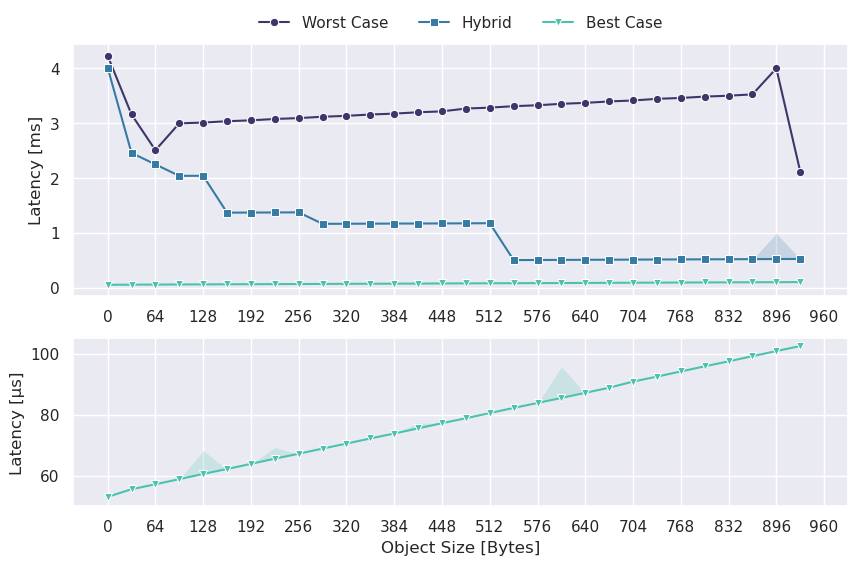

In [6]:
from util.plot import set_grid, save_plot, set_theme
from util.convert import scale_data
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

set_theme()
fig = plt.figure(1)
fig.set_figheight(6)
fig.set_figwidth(10)

gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1.5, 1]) 
ax = plt.subplot(gs[0])

unit = "ms"

if enable_storage_reference and len(storage_write) != 0:
    storage_write_scaled = scale_data(storage_write, unit)
    sns.lineplot(ax=ax, x=storage_write_scaled["options.object_size"], y=storage_write_scaled["mean"], label="Raw Write", markers=["o"], marker="X", color="#aaaaaa")

if len(allocate_max) != 0:
    allocate_max_scaled = scale_data(allocate_max, unit)
    sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
    ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_case1) != 0:
    allocate_case1_scaled = scale_data(allocate_case1, unit)
    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Hybrid", markers=["o"], marker="s")
    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_grid(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel(None)
ax.set_ylabel(f"Latency [{unit}]")
#plt.axis([200, 300, 10000, 15000])
#ax.set_ylim(bottom=-4, top=60)

if enable_storage_reference:
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(handles.pop(0))
    labels.append(labels.pop(0))
    ax.legend(handles, labels, loc = "lower center", bbox_to_anchor=(.5, 1), ncol=len(ax.legend().get_lines()), title=None, frameon=False)
else:
    ax.legend(loc = "lower center", bbox_to_anchor=(.5, 1), ncol=len(ax.legend().get_lines()), title=None, frameon=False)


set_theme(3, 2)
ax = plt.subplot(gs[1])

unit = "µs"

# if len(allocate_max) != 0:
#     allocate_max_scaled = scale_data(allocate_max, unit)
#     sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
#     ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

#if len(allocate_case1) != 0:
#    allocate_case1_scaled = scale_data(allocate_case1, unit)
#    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Additional Example", markers=["o"], marker="s")
#    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if enable_storage_reference and len(storage_write) != 0:
    storage_write_scaled = scale_data(storage_write, unit)
    sns.lineplot(ax=ax, x=storage_write_scaled["options.object_size"], y=storage_write_scaled["mean"], label="Raw Write", markers=["o"], marker="X", color="#aaaaaa")

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_grid(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel(f"Latency [{unit}]")
#plt.axis([200, 300, 10000, 15000])
ax.set_ylim(bottom=50, top=105)
ax.get_legend().remove()

save_plot("allocate", save_asset=False)

# Same Plot in Presentation Style

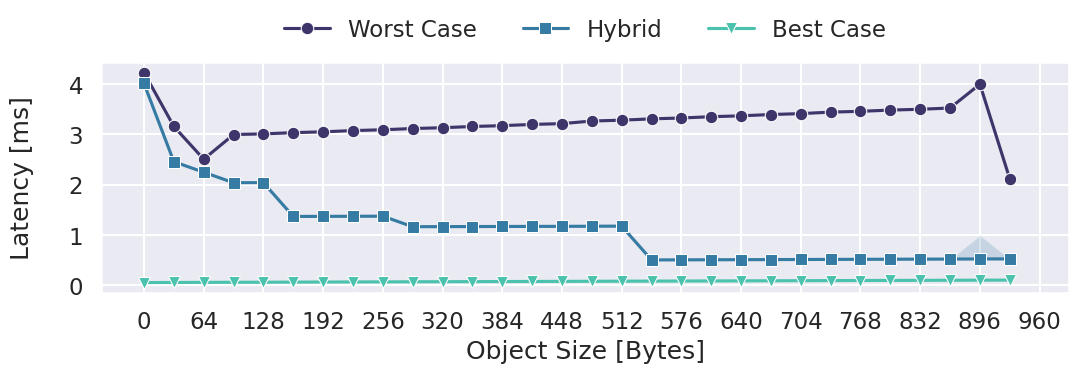

In [7]:
from util.plot import set_grid, save_plot, set_theme
from util.convert import scale_data
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

set_theme()
sns.set_context(context="talk")
fig = plt.figure(1)
fig.set_figheight(3)
fig.set_figwidth(12.5)

gs = gridspec.GridSpec(nrows=1, ncols=1) 
ax = plt.subplot(gs[0])

unit = "ms"

if enable_storage_reference and len(storage_write) != 0:
    storage_write_scaled = scale_data(storage_write, unit)
    sns.lineplot(ax=ax, x=storage_write_scaled["options.object_size"], y=storage_write_scaled["mean"], label="Raw Write", markers=["o"], marker="X", color="#aaaaaa")

if len(allocate_max) != 0:
    allocate_max_scaled = scale_data(allocate_max, unit)
    sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
    ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_case1) != 0:
    allocate_case1_scaled = scale_data(allocate_case1, unit)
    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Hybrid", markers=["o"], marker="s")
    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

set_grid(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

if enable_storage_reference:
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(handles.pop(0))
    labels.append(labels.pop(0))
    ax.legend(handles, labels, loc = "lower center", bbox_to_anchor=(.5, 1), ncol=len(ax.legend().get_lines()), title=None, frameon=False)
else:
    ax.legend(loc = "lower center", bbox_to_anchor=(.5, 1), ncol=len(ax.legend().get_lines()), title=None, frameon=False)

set_grid(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel(f"Latency [{unit}]", labelpad=25)
#plt.axis([200, 300, 10000, 15000])

plt.savefig(f"../figures/allocate_presentation_1.pdf", bbox_inches='tight', facecolor='#fafafa')


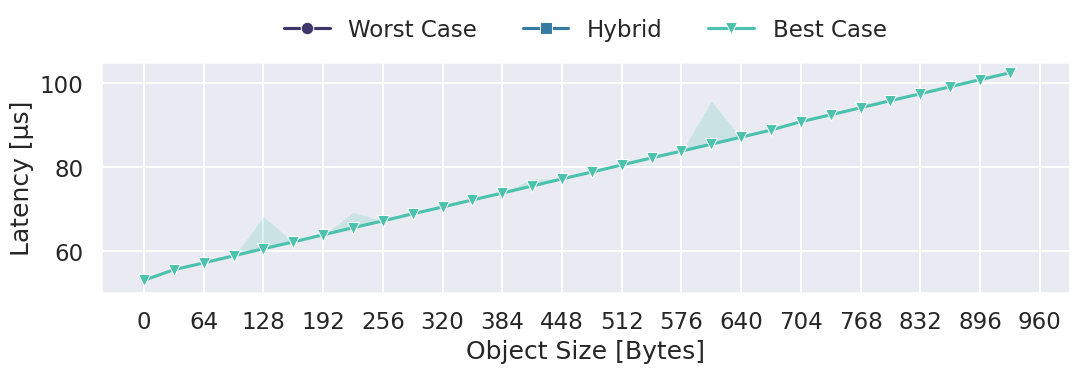

In [8]:
from util.plot import set_grid, save_plot, set_theme
from util.convert import scale_data
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(1)
fig.set_figheight(3)
fig.set_figwidth(12.5)

gs = gridspec.GridSpec(nrows=1, ncols=1) 

set_theme()
sns.set_context(context="talk")
ax = plt.subplot(gs[0])

unit = "µs"

if len(allocate_max) != 0:
     allocate_max_scaled = scale_data(allocate_max, unit)
     sns.lineplot(ax=ax, x=allocate_max_scaled["options.object_size"], y=allocate_max_scaled["mean"], label="Worst Case", markers=["o"], marker="o")
     ax.fill_between(allocate_max_scaled["options.object_size"], allocate_max_scaled["min"], allocate_max_scaled["max"], alpha=0.2, **fill_between_args)

if len(allocate_case1) != 0:
    allocate_case1_scaled = scale_data(allocate_case1, unit)
    sns.lineplot(ax=ax, x=allocate_case1_scaled["options.object_size"], y=allocate_case1_scaled["mean"], label="Hybrid", markers=["o"], marker="s")
    ax.fill_between(allocate_case1_scaled["options.object_size"], allocate_case1_scaled["min"], allocate_case1_scaled["max"], alpha=0.2, **fill_between_args)

if enable_storage_reference and len(storage_write) != 0:
    storage_write_scaled = scale_data(storage_write, unit)
    sns.lineplot(ax=ax, x=storage_write_scaled["options.object_size"], y=storage_write_scaled["mean"], label="Raw Write", markers=["o"], marker="X", color="#aaaaaa")

if len(allocate_min) != 0:
    allocate_min_scaled = scale_data(allocate_min, unit)
    sns.lineplot(ax=ax, x=allocate_min_scaled["options.object_size"], y=allocate_min_scaled["mean"], label="Best Case", markers=["o"], marker="v")
    ax.fill_between(allocate_min_scaled["options.object_size"], allocate_min_scaled["min"], allocate_min_scaled["max"], alpha=0.2, **fill_between_args)

if enable_storage_reference:
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(handles.pop(0))
    labels.append(labels.pop(0))
    ax.legend(handles, labels, loc = "lower center", bbox_to_anchor=(.5, 1), ncol=len(ax.legend().get_lines()), title=None, frameon=False)
else:
    ax.legend(loc = "lower center", bbox_to_anchor=(.5, 1), ncol=len(ax.legend().get_lines()), title=None, frameon=False)


set_grid(64, max(allocate_min["options.object_size"].max(), allocate_max["options.object_size"].max()), ax)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel(f"Latency [{unit}]")
#plt.axis([200, 300, 10000, 15000])
ax.set_ylim(bottom=50, top=105)

plt.savefig(f"../figures/allocate_presentation_2.pdf", bbox_inches='tight', facecolor='#fafafa')
